# Exercise 9: Classification

This homework assignment is designed to give you practice with classification models. We'll try to predict which words are more likely to be responded to correctly during a lexical decision task, based on their length and frequency.

We will be using data from the English Lexicon Project again. However, this time we will use response correctness as our dependent variable. Load **LexicalData_withIncorrect.csv**, which includes incorrect trials as well as correct ones, and also **Items.csv**. Both can be found in the *Homework/lexDat* folder in the class GitHub repository. 

This data is a subset of the [English Lexicon Project database](https://elexicon.wustl.edu/). It provides response correctness and reaction times (in milliseconds) of many subjects as they are presented with letter strings and asked to decide, as quickly and as accurately as possible, whether the letter string is a word or not. The **Items.csv** provides characteristics of the words used, namely frequency (how common is this word?) and length (how many letters?). 

*Data courtesy of Balota, D.A., Yap, M.J., Cortese, M.J., Hutchison, K.A., Kessler, B., Loftis, B., Neely, J.H., Nelson, D.L., Simpson, G.B., & Treiman, R. (2007). The English Lexicon Project. Behavior Research Methods, 39, 445-459.*

---
## 1. Loading and formatting the data (1 point)

Load in data from the **LexicalData_withIncorrect.csv** and **Items.csv** files. Use `left_join` to add word characteristics `Length` and `Log_Freq_Hal` from **Items** to the **LexicalData**, and use `drop_na()` to get rid of any observations with missing values. Then use `head()` to look at the first few rows of the data. 

*Note: We're just working with `Correct` in this homework, so no need to worry about reformatting reaction times.*

In [2]:
# WRITE YOUR CODE HERE
library(tidyverse)
library(dplyr)

setwd("/Users/ddbutler/Desktop/repos_new/Butler_DSPN_S24/Homework/lexDat")
items_df <- read.csv(file = "Items.csv") 
lex_data <- read.csv(file = "LexicalData_withIncorrect.csv") %>%
    left_join(items_df, by = c("D_Word" = "Word")) %>%
    drop_na()

head(lex_data)

,X,Sub_ID,Trial,Type,D_RT,D_Word,Outlier,D_Zscore,Correct,Occurrences,Length,Freq_HAL,Log_Freq_HAL
,<int>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>,<chr>,<dbl>
1,1,157,1,1,710,browse,false,-0.437,1,2,6,"7,016",8.856
2,2,67,1,1,"1,094",refrigerant,false,0.825,1,3,11,104,4.644
3,3,120,1,1,587,gaining,false,-0.645,1,4,7,"4,039",8.304
4,4,21,1,1,984,cheerless,false,0.025,1,4,9,14,2.639
5,5,236,1,1,577,pattered,false,-0.763,1,4,8,4,1.386
6,6,236,2,1,715,conjures,false,-0.364,1,4,8,194,5.268


---
## 2. Visualizing the data (1 point)

First, we'll try to visualize whether trials that are responded to correctly versus incorrectly differ from each other in terms of word length and log frequency. The code is included below, so that this homework doesn't get too cumbersome. All you have to do is **change the name of the data set**, **run the code**, and **write some observations about the output**.

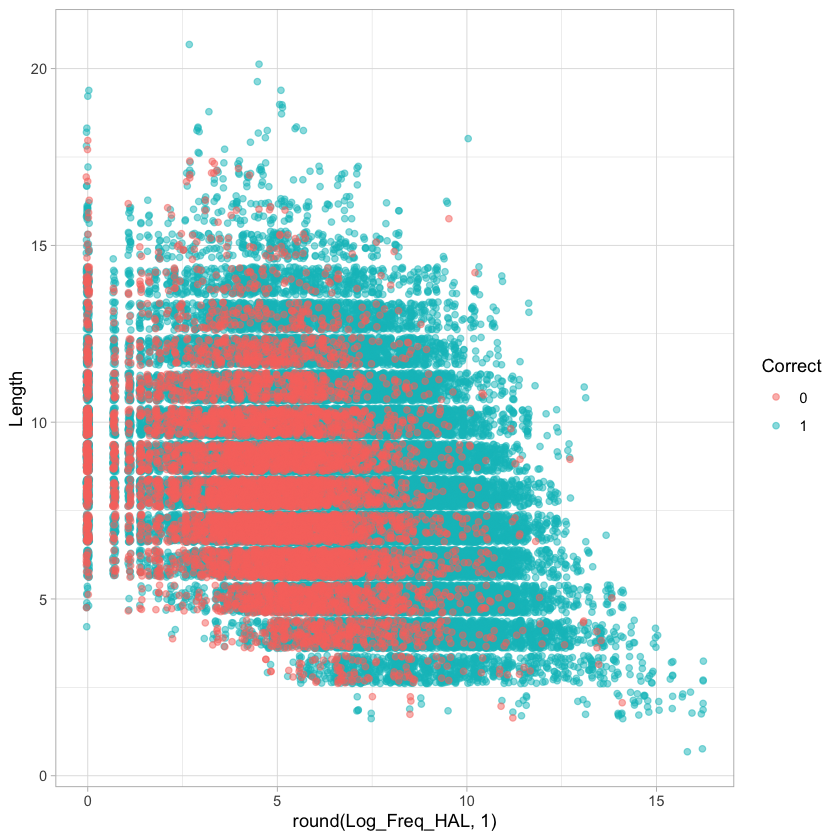

In [6]:
#vrequire(tidyverse) # Load the tidyverse package, if you haven't yet
lex_data$Correct <- as.factor(lex_data$Correct) # so that R knows that Correct is categorical, not numeric. 

# plot the Correct / Incorrect clusters
ggplot(lex_data,aes(x=round(Log_Freq_HAL,1),y=Length,col=Correct)) + geom_point(position="jitter",alpha=0.5) + theme_light() 


What do you observe about the "Correct" and "Incorrect" clusters? 

> *Write your reponse here* 

> There seems to be some overlap between the correct and incorrect clusters, but there seems to be more variability in the correct cluster.

---
## 3. Logistic Regression: Fitting the model (2 points)

Fit a logistic regression model to the data using `Length`, `Log_Freq_HAL`, and their interaction to predict `Correct`. Use `glm()` to fit the model, and look at its output using `summary()`.

In [8]:
# WRITE YOUR CODE HERE
# Run the GLM
glm.fit = glm(Correct~Length * Log_Freq_HAL, data=lex_data, family=binomial) # logistic regression 

# Summarize
summary(glm.fit)



Call:
glm(formula = Correct ~ Length * Log_Freq_HAL, family = binomial, 
    data = lex_data)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -0.939996   0.115623  -8.130 4.30e-16 ***
Length               0.151266   0.012789  11.828  < 2e-16 ***
Log_Freq_HAL         0.394772   0.018762  21.041  < 2e-16 ***
Length:Log_Freq_HAL -0.010558   0.002202  -4.795 1.63e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 49809  on 70588  degrees of freedom
Residual deviance: 46563  on 70585  degrees of freedom
AIC: 46571

Number of Fisher Scoring iterations: 5


What can you conclude from this output? (a brief gist is fine)

> *Write your response here* 

> The interaction between length and log_freq_HAL has a negative relationship with the probability that subject gets a word correct.

---
## 4. Interpreting predictions from the model (3 points)

Finally, look at how well this logistic regression model does at predicting correctness. Use `predict()` and a threshold of 0.5 to generate predicted `Correct` values for each trial, then output a confusion matrix and overall accuracy for these predictions.

*Hint: see the Classifiers tutorial.*

In [16]:
# WRITE YOUR CODE HERE


# Get predicted probabilities
glm_prob_df = data.frame(predict(glm.fit, type = "response"))
colnames(glm_prob_df) = c('predicted_prob')

num_observations = nrow(lex_data)

# First make a list of incorrects as 0
glm_prob_df$predicted_binary = rep(0,num_observations)

# Use the probability output to label the correct responses. Let's use a threshold of 50% probability. 
threshold = 0.50 # binarizing threshold 
glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>threshold]=1 #find the rows that have prob > threshold and cast as correct as 1

# Now let's look at the prediction accuracy
confusion_df = data.frame(glm_prob_df$predicted_binary, lex_data$Correct)
colnames(confusion_df) = c('predicted', 'actual')
table(confusion_df)

# We can calculate the prediction accuracy by counting the number of times our
# prediction vector matched the real data and taking the average
print(paste("Accuracy:",mean(confusion_df$predicted == confusion_df$actual)))

head(glm_prob_df)



# # Then use the probability output to label the up days. Let's use a threshold of 50% probability. 
# glm_prob_df$predicted_binary[glm_prob_df$predicted_prob>threshold]="Up" #find the rows that have prob > threshold and cast as 'up'



# table(confusion_df)


         actual
predicted     0     1
        0    13    44
        1  7966 62566

[1] "Accuracy: 0.886526229299183"


,predicted_prob,predicted_binary
,<dbl>,<dbl>
1,0.9479784,1
2,0.8826628,1
3,0.9417677,1
4,0.7707288,1
5,0.6682356,1
6,0.8704362,1


In [22]:
glm_prob_df %>% filter(predicted_binary==0)

,predicted_prob,predicted_binary
,<dbl>,<dbl>
876,0.4542122,0
2301,0.4919008,0
5656,0.4919008,0
5947,0.4919008,0
6057,0.4919008,0
7456,0.4919008,0
7799,0.4919008,0
8100,0.4919008,0
8272,0.4919008,0


Did the model do well at predicting lexical decision correctness? Why or why not? 

> *Write your response here*  

> The model did rather well overall at predicting lexical decision correctness with an accuracy of 0.88. However,it did not do well at predicting incorrect cases, perhaps because it was given less examples of incorrect cases in the training data or because many of the incorrect cases overlap with the correct cases in word length.

## 5. QDA (3 points)

Load in the `MASS` library and fit a QDA model to the data set. The predictors are still `Length`, `Log_Freq_HAL`, and their interaction, just like the logistic regression model you just ran, and the dependent variable is still `Correct`. 

*Hint: see the Classifiers tutorial.*

In [23]:
# WRITE YOUR CODE HERE
library(MASS)

# QDA is also part of the MASS library
qda.fit = qda(Correct~Length * Log_Freq_HAL, data=lex_data)
qda.fit



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




Call:
qda(Correct ~ Length * Log_Freq_HAL, data = lex_data)

Prior probabilities of groups:
        0         1 
0.1130346 0.8869654 

Group means:
    Length Log_Freq_HAL Length:Log_Freq_HAL
0 8.047124     4.932123            37.95260
1 7.979971     6.444849            49.34219

Now look at how well the predicted `Correct` values compare with actual `Correct` values for the whole data set. Output a confusion matrix and overall prediction accuracy. 

In [25]:
# WRITE YOUR CODE HERE
# Same basic predictions as LDA, just assuming that each distribution has its own variance. 
# But we work with coefficients the same way.
qda.class=predict(qda.fit, lex_data)$class
table(qda.class, lex_data$Correct)
print(paste("Accuracy:",mean(qda.class==lex_data$Correct)))


         
qda.class     0     1
        0   455  1647
        1  7524 60963

[1] "Accuracy: 0.870078907478502"


How does QDA prediction performance differ from that of logistic regression?

> *Write your response here* 
>  The accuracy went down.

**DUE:** 5pm EST, March 11, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*